## Denoising autoencoder
Attempts to recreate appliance signature from aggregate signal by finding a samller representation then reconstructing the signal from this.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
X1 = pd.read_csv('../../master_data/nilm/kettle_input.dat', header = 0, delim_whitespace = True,
                                index_col = 0)
X2 = pd.read_csv('../../master_data/nilm/syntethic_kettle_dae.dat', header = 0, delim_whitespace = True,
                                index_col = 0)
y1 = pd.read_csv('../../master_data/nilm/kettle_signatures.dat', header = 0, delim_whitespace = True,
                                index_col = 0)
y2 = pd.read_csv('../../master_data/nilm/syntethic_kettle_dae_response.dat', header = 0, delim_whitespace = True,
                                index_col = 0)

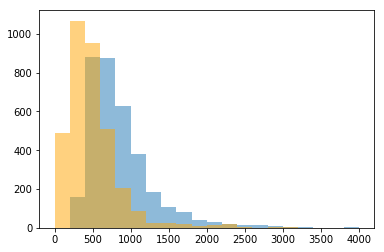

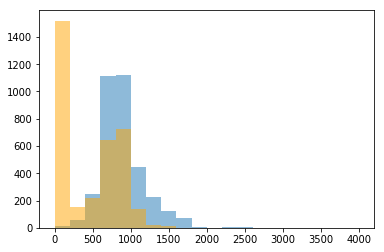

In [3]:
#Comparing the syntethic and the real data
means_real = X1.mean(axis=1).sort_values().reset_index(drop=True)
means_synth = X2[:means_real.size].mean(axis=1).sort_values().reset_index(drop=True)
plt.hist(means_real,alpha=0.5, bins=20, range=(0,4000))
plt.hist(means_synth,alpha=0.5,color='orange', bins=20, range=(0,4000))
plt.show()

stds_real = X1.std(axis=1).sort_values().reset_index(drop=True)
stds_synth = X2[:stds_real.size].std(axis=1).sort_values().reset_index(drop=True)
plt.hist(stds_real,alpha=0.5,bins=20, range=(0,4000))
plt.hist(stds_synth,alpha=0.5,color='orange',bins=20, range=(0,4000))
plt.show()

The difference in mean is due to the large number of no-signal samples in the syntethic data. This also explains the 0-deviation data.

In [164]:
#real_data = pd.concat([training_set_kettle,response_kettle],axis=1)

col_dict = dict(zip(X1.columns.values,X2.columns.values))
X = X2.append(X1.rename(columns=col_dict))

y = y2.append(y1)

print(X.shape)
print(y.shape)

X_np = np.array(X,dtype=np.float64).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y,dtype=np.float64).reshape((y.shape[0],y.shape[1]))

#some cleaning (some of the syntethic data contained 0-length signals?)
dirty = []
for i in range(y_np.shape[0]):
    if np.isnan(y_np[i]).any() or y_np[i].mean() == 0:#assume signal present.
        dirty.append(i)
y_np = np.delete(y_np, dirty,axis=0)
X_np = np.delete(X_np, dirty,axis=0)

print("Removed " + str(len(dirty)) + " instances.")
#row_mean = syntethic_data.mean(axis=1)
#syntethic_data_n = syntethic_data.sub(row_mean.T,axis=0)
#rand_sd = syntethic_data.std(axis=1)
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
#syntethic_data_n = syntethic_data_n.div(rand_sd,axis=0)
#syntethic_data_n.head()



(13433, 128)
(13433, 128)
Removed 5092 instances.


5133


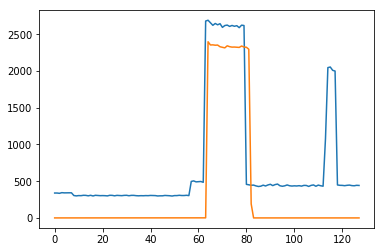

In [241]:
dice = np.random.randint(0,y_np.shape[0])

print(dice)
plt.plot(X_np[dice])
plt.plot(y_np[dice])
plt.show()

In [88]:
sample_length = X.shape[1]

In [120]:
mean = X_np.mean(axis=1).reshape(X_np.shape[0],1,1)
#mean = 0.0
X_np = X_np - mean
sd = X_np.std(axis=1).mean()
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())


Mean:  -9.42226411438e-21
Std:  1.04168682526


In [121]:
normalization_params = pd.DataFrame([[mean,sd]],columns=['mean','sd'])
normalization_params.to_csv('C:/Users/bfesc/Documents/Master_thesis/master_data/nilm/normalization_params_dAE.csv', sep=' ')

In [127]:
layer1 = Conv1D(filters=8, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='same', strides=1)
layer1_b = Flatten()
layer2 = Dense(units=(sample_length-3)*8,activation='relu')
layer3 = Dense(units=128,activation='relu')
layer4 = Dense(units=(sample_length-3)*8,activation='relu')
layer5 = Conv1D(filters=1,kernel_size=4,activation='linear',padding='same', strides=1)

model = Sequential()

model.add(layer1)
#model.add(layer1_b)
model.add(layer2)
model.add(layer3)
model.add(layer4)
model.add(layer5)


In [128]:
y_np = y_np.reshape(y_np.shape[0],y_np.shape[1],1)
print(X_np.shape, y_np.shape)
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mae'])

training_history = model.fit(X_np, y_np, batch_size=64,verbose=1,epochs=10, validation_split=0.1)

(8341, 128, 1) (8341, 128, 1)
Train on 7506 samples, validate on 835 samples
Epoch 1/10
7506/7506 [==============================] - 77s 10ms/step - loss: 159404.0525 - mean_absolute_error: 138.8198 - val_loss: 296828.5736 - val_mean_absolute_error: 217.7379
Epoch 2/10
7506/7506 [==============================] - 75s 10ms/step - loss: 106801.0111 - mean_absolute_error: 107.6896 - val_loss: 257877.3858 - val_mean_absolute_error: 195.6210
Epoch 3/10
7506/7506 [==============================] - 79s 11ms/step - loss: 98145.9954 - mean_absolute_error: 101.2970 - val_loss: 243180.0001 - val_mean_absolute_error: 179.1912
Epoch 4/10
7506/7506 [==============================] - 79s 11ms/step - loss: 91210.6340 - mean_absolute_error: 94.4687 - val_loss: 211152.8820 - val_mean_absolute_error: 165.7357
Epoch 5/10
7506/7506 [==============================] - 85s 11ms/step - loss: 84934.3440 - mean_absolute_error: 88.5853 - val_loss: 204692.5006 - val_mean_absolute_error: 158.6130
Epoch 6/10
7506/75

In [130]:
model.save('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\nilm\\models\\model0129bdAE.h5')

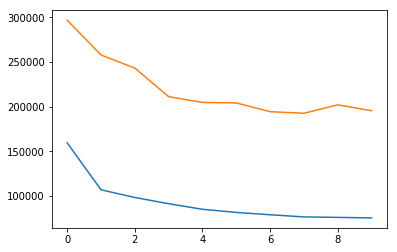

In [129]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.show()